In [102]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import mylibrary.nnlib as tnn
import mylibrary.dynamicnnlib as tdnn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [138]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y0 = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
    return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)]
Y1 = np.zeros(X1.shape)
for p in gprms:
    Y1 += gaussian(X1, X2, *p)
    
Y2 = np.cos(np.sqrt((X1-0.5)**2 + X2**2))*2-1.

In [139]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y0 = 2*(Y0 - Y0.min())/(Y0.max() - Y0.min()) -1
Y1 = 2*(Y1 - Y1.min())/(Y1.max() - Y1.min()) -1
Y2 = 2*(Y2 - Y2.min())/(Y2.max() - Y2.min()) -1


x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy0 = Y0.reshape(-1,1)
yy1 = Y1.reshape(-1,1)
yy2 = Y2.reshape(-1,1)

yy = np.concatenate([yy0, yy1, yy2], axis=1)
print(yy.shape)

(2500, 3)


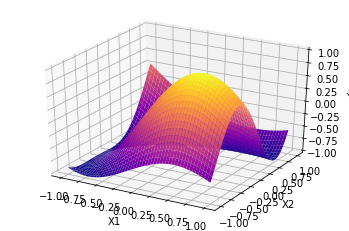

In [140]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y2, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [177]:
optim = tnn.Adam(0.01)
linear = tnn.LinearLayer(2, 3, optimizer=optim)
layer1 = tnn.NonLinearLayer(2, 6, tdnn.Relu_1Linear(), optimizer=optim)
layer2 = tnn.LinearLayer(6, 3, optimizer=optim)

In [178]:
try:
    for epoch in range(100000):
        yr = linear.forward(xx)
        a1 = layer1.forward(xx)
        a2 = layer2.forward(a1)
        yout = yr + a2

        dy = yout - yy
        da1 = layer2.backward(dy)
        dxa = layer1.backward(da1)
        dxr = linear.backward(dy)
        dx = dxr + dxa

        linear.update()
        layer1.update()
        layer2.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
except:
    pass

0 Error =  0.8811435403604679
100 Error =  0.04297164864123154
200 Error =  0.03665164428604552
300 Error =  0.0344898129454483
400 Error =  0.03234046520768004
500 Error =  0.028799089744453332
600 Error =  0.023745759932214682
700 Error =  0.019176521813517023
800 Error =  0.01571718097045253
900 Error =  0.013771906266757108
1000 Error =  0.013086627841120692
1100 Error =  0.012795231335069672
1200 Error =  0.012585941224844919
1300 Error =  0.01241421926122686
1400 Error =  0.012267618366609235
1500 Error =  0.012147303992127476
1600 Error =  0.012043035127658202
1700 Error =  0.011952745980397507
1800 Error =  0.011872372186486508
1900 Error =  0.011796235334543888
2000 Error =  0.011717408614511579
2100 Error =  0.011639669543507682
2200 Error =  0.011566888553917156
2300 Error =  0.011491286782552273
2400 Error =  0.011420000325044378
2500 Error =  0.011355356133076517
2600 Error =  0.011299894390588167
2700 Error =  0.011250857333360044
2800 Error =  0.011209456587428555


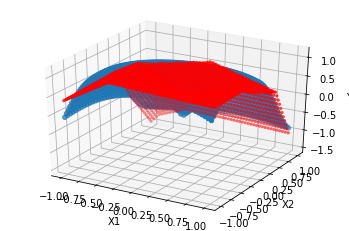

In [179]:
i=0
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, yy[:,i])
ax.scatter(X1, X2, yout[:,i], color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
fig.canvas.draw()

### training layer2 by removing shortcut (linear) layer

In [180]:
inp = layer1.output
out = yout
for epoch in range(5000):
    a2 = layer2.forward(inp)
    da2 = a2 - out
    
    layer2.backward(da2)
    layer2.update()

    if epoch%1000 == 0:
        error = tnn.MseLoss().loss(a2, out)
        print(epoch, 'Error = ', error)

0 Error =  0.8352725038298738
1000 Error =  0.00433582592034878
2000 Error =  0.004284479295984698
3000 Error =  0.004284340755861946
4000 Error =  0.004284340748768065


In [181]:
a2

array([[ 0.7434883 ,  0.06195265, -1.24287515],
       [ 0.7449858 ,  0.00681538, -1.21503487],
       [ 0.7464833 , -0.04832189, -1.18719458],
       ...,
       [-0.94711213,  0.03837757, -0.99231689],
       [-0.9466498 ,  0.02623912, -1.00863867],
       [-0.94618747,  0.01410066, -1.02496044]])

In [182]:
out

array([[ 0.38669703,  0.37486054, -0.95747201],
       [ 0.43519978,  0.27849417, -0.96725125],
       [ 0.48370252,  0.18212781, -0.97703048],
       ...,
       [-1.0354143 ,  0.11587276, -0.92156893],
       [-1.03910561,  0.10738177, -0.93456234],
       [-1.04279693,  0.09889078, -0.94755576]])

In [183]:
a1 = layer1.forward(xx)
yout = layer2.forward(a1)
error = ((yout - yy)**2).mean()/2
print(error)

0.01595176639782629


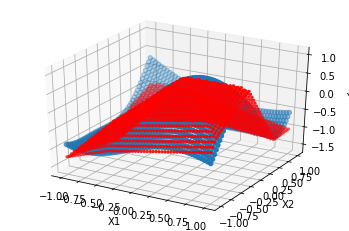

In [184]:
%matplotlib inline
i=2
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, yy[:,i])
ax.scatter(X1, X2, yout[:,i], color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
fig.canvas.draw()

In [187]:
try:
    for epoch in range(100000):
        a1 = layer1.forward(xx)
        a2 = layer2.forward(a1)
        yout = a2

        dy = yout - yy
        da1 = layer2.backward(dy)
        dxa = layer1.backward(da1)
        dx = dxa

        layer1.update()
        layer2.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
except:
    pass

0 Error =  0.011759839582248466
100 Error =  0.01175991895829758
200 Error =  0.01175994258265719
300 Error =  0.011759896729380735
400 Error =  0.011759787111893405
500 Error =  0.0117598790586456
600 Error =  0.011760856083479617
700 Error =  0.011782632027129307
800 Error =  0.011759893967370129
900 Error =  0.01176092829275307
1000 Error =  0.011759928140803191
1100 Error =  0.011759845289626458
1200 Error =  0.011764374006278966
1300 Error =  0.01176765064468281
1400 Error =  0.01180372009003215
1500 Error =  0.01175980993811648
1600 Error =  0.011759821960246466
1700 Error =  0.011760090839249643
1800 Error =  0.011760503063560579
1900 Error =  0.011764971734830503
2000 Error =  0.011778083801230455
2100 Error =  0.011760012525588929
2200 Error =  0.011759815033309824
2300 Error =  0.011759859147775917
2400 Error =  0.011776487564741332
2500 Error =  0.011760019812955746
2600 Error =  0.011759861494420829
2700 Error =  0.011762850120207774
